<a href="https://colab.research.google.com/github/LizLian/from_scratch_2025/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title MLP implementation based on the following paper https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
with open('names.txt', 'r') as f:
    names = f.read().splitlines()
print(names[:10])
print(len(names))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
32033


In [27]:
chars = sorted(list(set("".join(names))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi["."] = 0
itos = {i:c for c, i in stoi.items()}

In [28]:
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
block_size = 3

def build_dataset(names):
  X, Y = [], []
  for word in names:
    context = [0] * block_size
    for ch in word + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))
Xtrain, Ytrain = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtest, Ytest = build_dataset(names[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
n1

25626

In [6]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [7]:
# number of parameters in total
sum(p.nelement() for p in parameters)

17697

In [8]:
for p in parameters:
  p.requires_grad = True

In [39]:
# tune learning rate
lre = torch.linspace(-3, 0, 30000)
lrs = 10**lre

lri = []
lossi = []
stepi = []

In [44]:
for i in range(30000):
  # minibatch construct
  ix = torch.randint(0, Xtrain.shape[0], (32,))

  # forward pass
  emb = C[Xtrain[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2

  # cross entropy - manual
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdim=True)
  # loss = -prob[torch.arange(12), Y].log().mean()

  # cross entropy by pytorch
  loss = F.cross_entropy(logits, Ytrain[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lrs[i]
  lr = 0.01
  # lr decay (when it gets closer to the min, lower the lr)
  # lr = 0.01
  for p in parameters:
    p.data += -lr*p.grad # try different lr, 1 to -0.01, 1 is a exploding lr

  # track lr stats
  lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
# print(loss.item())

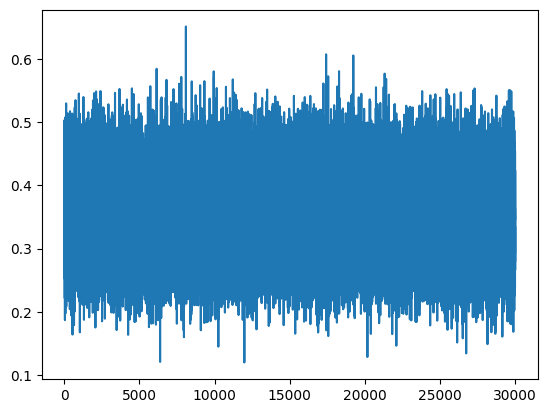

In [47]:
plt.plot(stepi, lossi)

In [45]:
# train data loss
emb = C[Xtrain]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytrain)
loss

tensor(2.1220, grad_fn=<NllLossBackward0>)

In [46]:
# dev data loss
# beat 2.1701
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1822, grad_fn=<NllLossBackward0>)

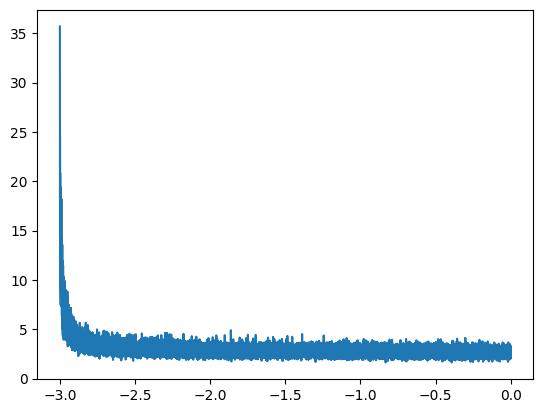

In [14]:
plt.plot(lri, lossi)
# we can see from the plot a good lr is when the exponent is -1 (lr = 0.1)

In [17]:
C[:, 0]

tensor([ 2.8386, -0.1390,  2.0485, -0.1979,  0.0877,  0.0344, -0.0224,  0.0175,
        -0.0084,  0.0695, -0.0455,  0.1899, -0.0456, -1.1523,  0.2404,  0.1441,
         0.1783,  2.0708,  0.2583,  0.0696,  0.1971,  0.1609,  0.8212, -0.0231,
         0.0358, -0.1727,  0.1432], grad_fn=<SelectBackward0>)

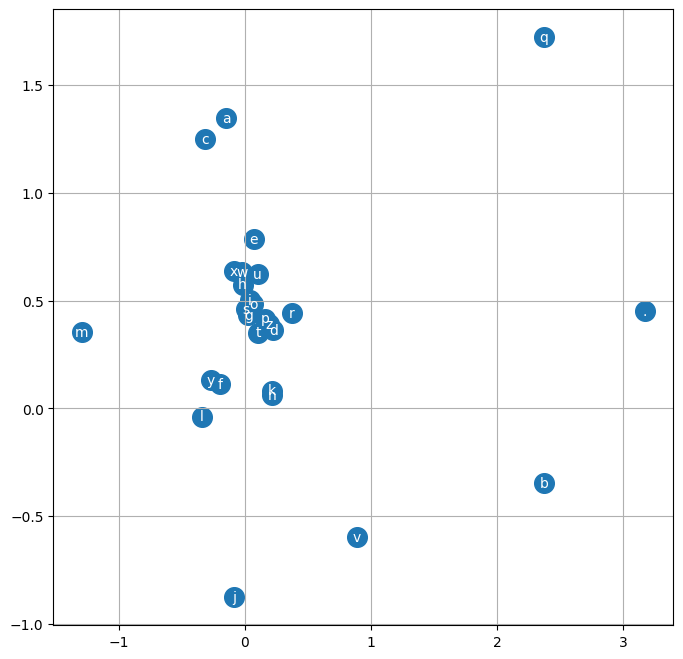

In [36]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [50]:
# @title Sample from the model
for _ in range(20):
  out = []
  context = [0] * block_size # intialize with all ...
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, d)
    h = torch.tanh(emb.view(1, -1)@ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print("".join(itos[i] for i in out))

kanttem.
mel.
khysleena.
morie.
jaquanna.
katrroner.
anterra.
kameek.
zail.
elayna.
dever.
antn.
jayviel.
seus.
adas.
zansentell.
danalaya.
mira.
marie.
maisen.
